In [1]:
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from datasets import datasets
from utils import PCP_Group
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold

In [2]:
np.random.seed(123456)

alpha = 0.1
X, Y = datasets.GetDataset("meps_19", "datasets/")
A = X[:,-1]
P = np.mean(A)
X = np.concatenate([X, 1-A[:,None]],axis=1)
feature = X.shape[1]-1

In [ ]:
# Store the coverage rates
rate_scp_ave = []
rate_scp_p_ave = []
rate_pcp_ave = []

# Store the quantiles
q_scp_ave = []
q_scp_p_ave = []
q_pcp_ave = []

# Store the group-conditional coverage rates
r_m_scp_ave = []
r_m_scp_p_ave = []
r_m_pcp_ave = []

# Store the covariance
c_scp_p_ave = []
c_pcp_ave = []

def ave(coverage_ii, q_ii,test_index,index):
    return np.mean(np.array(coverage_ii)[test_index][index]), np.mean(np.array(q_ii)[test_index][index])

for k in range(200):
    
    # Train two random forest models with and without the sensitive attribute
    list_full = np.random.choice(len(X), 8000, replace=False)
    X_0, X_train, Y_0, Y_train = train_test_split(X[list_full], Y[list_full],test_size=2000)
    
    mean_Y = np.mean(Y_train)
    std_Y = np.std(Y_train)
    Y_train = (Y_train-mean_Y)/std_Y
    Y_0 = (Y_0-mean_Y)/std_Y

    X_train_ = np.delete(X_train,feature,1)
    X_train_ = np.delete(X_train_,feature-1,1)
    forest =  RandomForestClassifier().fit(X_train_, X_train[:,feature])
    RF = RandomForestRegressor().fit(X_train,Y_train)
    RF_ = RandomForestRegressor().fit(X_train_,Y_train)
    X_val, X_test, Y_val, Y_test = train_test_split(X_0, Y_0, test_size=4000)

    n_val = X_val.shape[0]
    n_test = X_test.shape[0]
    
    X_val_ = np.delete(X_val,feature,1)
    X_val_ = np.delete(X_val_,feature-1,1)
    
    X_test_ = np.delete(X_test,feature,1)
    X_test_ = np.delete(X_test_,feature-1,1)

    R_val_ = abs(Y_val - RF_.predict(X_val_))
    R_test_ = abs(Y_test - RF_.predict(X_test_))

    R_val = abs(Y_val - RF.predict(X_val))
    R_test = abs(Y_test - RF.predict(X_test))

    # Store the coverage and quantiles of SCP, SCP+Partition and PCP
    coverage_scp = []
    coverage_scp_p = []
    coverage_pcp = []
    
    Q_scp_list = []
    Q_scp_p_list = []
    Q_pcp_list = [] 

    # Compute the intervals of SCP, SCP+Partition and PCP
    R = np.hstack((R_val,np.inf))
    prob_v = forest.predict_proba(X_val_)
    prob_t = forest.predict_proba(X_test_)

    for j in tqdm(range(n_test)):
        
        b_1 = np.zeros(n_val+1)
        b_1[-1] =  1
        b_1[:-1] = (X_val[:,feature]==X_test[j,feature])
        b_j = b_1/np.sum(b_1)
        
        Q_scp = np.quantile(R,1-alpha)
        coverage_scp.append(R_test[j]<=Q_scp)

        Q_scp_p = DescrStatsW(R,b_j).quantile(probs=1-alpha, return_pandas=False)[0]
        coverage_scp_p.append(R_test[j]<=Q_scp_p)

        Q_scp_list.append(2*Q_scp)
        Q_scp_p_list.append(2*Q_scp_p) 

    prob_cv = np.zeros((np.shape(X_train_)[0],2))
    kf = KFold(n_splits=10, shuffle=True)
    for train_index_cv, test_index_cv in kf.split(X_train_):
        RF_cv =  RandomForestClassifier().fit(X_train_[train_index_cv],X_train[train_index_cv,feature])
        prob_cv[test_index_cv] = RF_cv.predict_proba(X_train_[test_index_cv])

    indicator = (prob_cv[:,1]<P)*X_train[:,feature]
    PCP_model = PCP_Group(prob_cv[np.where(indicator)[0]],indicator)
    Q_pcp_list, coverage_pcp, prob_list = PCP_model.calibrate(prob_v, prob_t, R_val_, R_test_, X_val[:,feature], X_test[:,feature], alpha, finite=True)
    Q_pcp_list = 2*np.array(Q_pcp_list)

    print(PCP_model.m)
    
    num_samples = np.shape(X_test_)[0]
    num_test_samples = int(0.5 * num_samples)
    test_index = np.random.choice(num_samples, size=num_test_samples, replace=False)
    train_index = np.setdiff1d(np.arange(num_samples), test_index)

    # Compute the covariance for SCP+Partition
    m_1 = RandomForestRegressor().fit(X_test_[train_index], RF.predict(X_test[train_index]) - np.array(Q_scp_p_list)[train_index]/2)
    m_2 = RandomForestClassifier().fit(X_test_[train_index], X_test[train_index,feature])
    r_1 = RF.predict(X_test[test_index]) - np.array(Q_scp_p_list)[test_index]/2 - m_1.predict(X_test_[test_index])
    r_2 = X_test[test_index,feature]- m_2.predict_proba(X_test_[test_index])[:,1]
    r_12 = r_1*r_2
    stat_scp_p = np.mean(r_12)/np.sqrt(np.mean(r_12**2)- np.mean(r_12)**2)

    # Compute the covariance for PCP
    m_1 = RandomForestRegressor().fit(X_test_[train_index], RF_.predict(X_test_[train_index]) - np.array(Q_pcp_list)[train_index]/2)
    m_2 = RandomForestClassifier().fit(X_test_[train_index], X_test[train_index,feature])
    r_1 = RF_.predict(X_test_[test_index]) - np.array(Q_pcp_list)[test_index]/2 - m_1.predict(X_test_[test_index])
    r_2 = X_test[test_index,feature] - m_2.predict_proba(X_test_[test_index])[:,1]
    r_12 = r_1*r_2
    stat_pcp = np.mean(r_12)/np.sqrt(np.mean(r_12**2)- np.mean(r_12)**2)

    # Store the covariances
    c_scp_p_ave.append(stat_scp_p)
    c_pcp_ave.append(stat_pcp)

    q_scp = []
    q_scp_p = []
    q_pcp = []
    
    # Store the group-conditional coverage rates and quantiles
    index = np.where(X_test[test_index,feature] == 1)[0]
    rate_scp_1, q_scp_1  = ave(coverage_scp,Q_scp_list,test_index,index)
    rate_scp_p_1, scp_p_q_1  = ave(coverage_scp_p,Q_scp_p_list,test_index,index)
    rate_pcp_1, pcp_q_1  = ave(coverage_pcp,Q_pcp_list,test_index,index)

    r_m_scp_ave.append(rate_scp_1)
    r_m_scp_p_ave.append(rate_scp_p_1)
    r_m_pcp_ave.append(rate_pcp_1)

    # Store the coverage rates and quantiles conditional on the sensitivity attribute and e(X)
    rate_scp = []
    rate_scp_p = []
    rate_pcp = []

    for ii in range(2):

        index = np.where(((np.array(prob_list)[test_index]>P)==ii)*(X_test[test_index,feature] == 1))[0]
        rate_scp_1, q_scp_1  = ave(coverage_scp,Q_scp_list,test_index,index)
        rate_scp_p_1, scp_p_q_1  = ave(coverage_scp_p,Q_scp_p_list,test_index,index)
        rate_pcp_1, pcp_q_1  =  ave(coverage_pcp,Q_pcp_list,test_index,index)

        rate_scp.append(rate_scp_1)
        rate_scp_p.append(rate_scp_p_1)
        rate_pcp.append(rate_pcp_1)
        
        q_scp.append(q_scp_1)
        q_scp_p.append(scp_p_q_1)
        q_pcp.append(pcp_q_1)

    print(q_pcp)

    rate_scp_ave.append(rate_scp)  
    rate_scp_p_ave.append(rate_scp_p)  
    rate_pcp_ave.append(rate_pcp) 

    q_scp_ave.append(q_scp)  
    q_scp_p_ave.append(q_scp_p)  
    q_pcp_ave.append(q_pcp) 

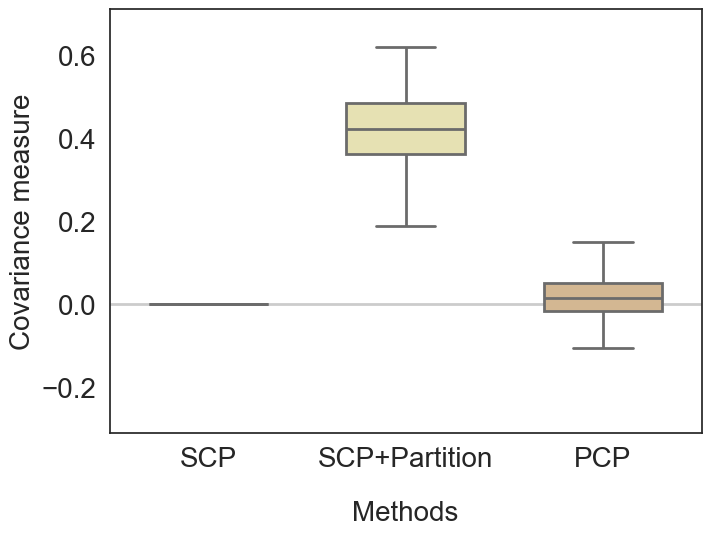

In [50]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

data = pd.DataFrame({'SCP': np.array(c_scp_p_ave)*0,'SCP+Partition': c_scp_p_ave, 'PCP': c_pcp_ave})
fig, ax = plt.subplots(layout='constrained', figsize=(7,5.25), dpi=100)
data_melted = data.melt(var_name='Group', value_name='Value')
my_pal = {'SCP': "silver",'SCP+Partition': "#EEE8AA" , 'PCP': "#DEB887"}
sns.set_theme(style="white", palette=None)

sns.boxplot(x='Group', y='Value', width=0.6, data=data_melted,fliersize=0,linewidth=2, palette=my_pal)
plt.axhline(y=0.000, color='black',alpha=0.2, zorder=0,linewidth=2)
ax.set_xlabel('Methods',fontsize=20, labelpad = 20)
ax.set_ylabel('Covariance measure',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(-0.31,0.71)
plt.yticks([-0.2,0.0,0.2,0.4,0.6])
plt.show()

In [51]:
size0 = len(Q_scp_list)
Q_scp_list = np.array(Q_scp_list)
Q_scp_p_list = np.array(Q_scp_p_list)
Q_pcp_list = np.array(Q_pcp_list)

In [52]:
q_scp_ave = np.array(q_scp_ave)
q_scp_p_ave = np.array(q_scp_p_ave)
q_pcp_ave = np.array(q_pcp_ave)

size1,size2 = q_scp_ave.shape
intervals =  np.array(size1*['[0, 0.36)','[0.36, 1.0)'])[:,None]
scp_ = np.concatenate([intervals, np.array(size1*size2*['SCP'])[:,None]],axis=1)
scp_p = np.concatenate([intervals, np.array(size1*size2*['SCP+Partition'])[:,None]],axis=1)
pcp_ = np.concatenate([intervals, np.array(size1*size2*['PCP'])[:,None]],axis=1)
data =pd.DataFrame(data=np.concatenate([scp_,scp_p,pcp_],axis=0),columns=['e','Method'])
data['y'] = np.concatenate([q_scp_ave.reshape(-1,1), q_scp_p_ave.reshape(-1,1), q_pcp_ave.reshape(-1,1)],axis=0)

/var/folders/5h/j8llxwt96fvfm80tyyz5hp5w0000gn/T/ipykernel_40276/2555178753.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


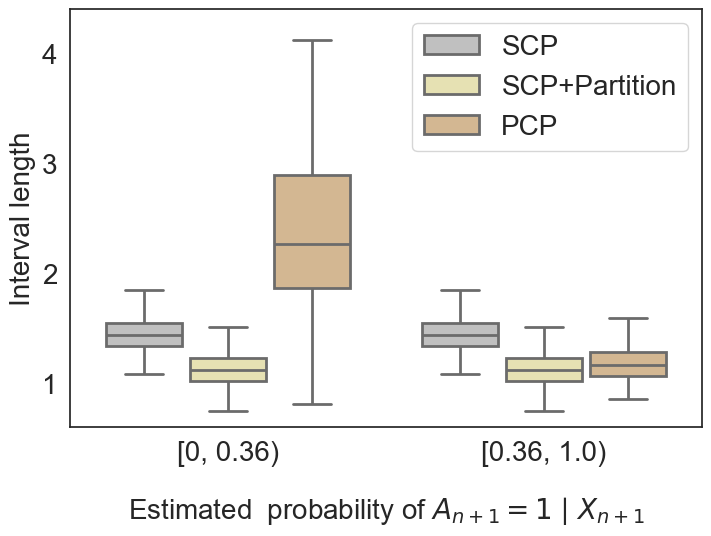

In [53]:
sns.set_palette(sns.color_palette(["silver", "#EEE8AA","#DEB887"]))

fig, ax = plt.subplots(layout='constrained', figsize=(7,5.25), dpi=100)
sns.boxplot(x = data['e'],  y = data['y'],  gap=0.1, hue = data['Method'], fliersize=0,linewidth=2)

ax.set_ylabel('Interval length',fontsize=20)
ax.set_xlabel('Estimated  probability of $A_{n+1}=1\mid X_{n+1}$',fontsize=20, labelpad =20)
ax.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.ylim(0.6,4.4)
plt.yticks([1,2,3,4],fontsize=20)
labels = ['[0, 0.36)','[0.36, 1.0)']
ax.set_xticklabels(labels)
plt.show()

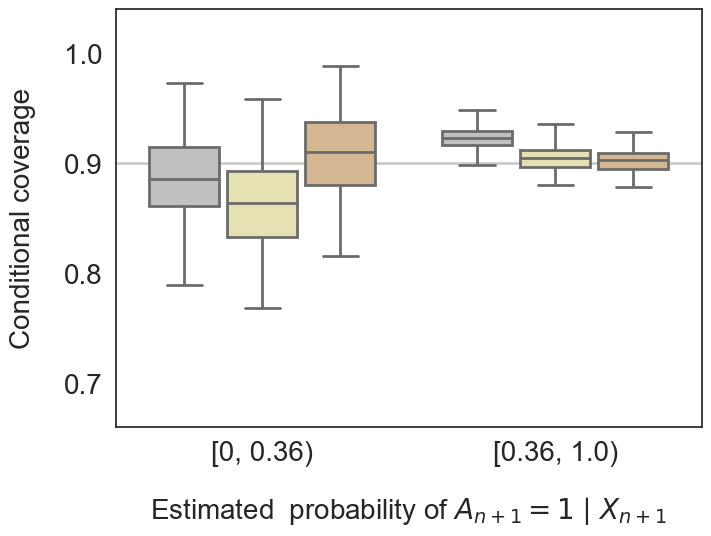

In [54]:
rate_scp_ave = np.array(rate_scp_ave)
rate_scp_p_ave = np.array(rate_scp_p_ave)
rate_pcp_ave = np.array(rate_pcp_ave)

size1,size2 = rate_scp_ave.shape

intervals =  np.array(size1*['[0, 0.36)','[0.36, 1.0)'])[:,None]
scp_ = np.concatenate([intervals, np.array(size1*size2*['SCP'])[:,None]],axis=1)
scp_p = np.concatenate([intervals, np.array(size1*size2*['SCP+Partition'])[:,None]],axis=1)
pcp_ = np.concatenate([intervals, np.array(size1*size2*['PCP'])[:,None]],axis=1)
data =pd.DataFrame(data=np.concatenate([scp_,scp_p,pcp_],axis=0),columns=['e','Method'])
data['y'] = np.concatenate([rate_scp_ave.reshape(-1,1),rate_scp_p_ave.reshape(-1,1),rate_pcp_ave.reshape(-1,1)],axis=0)

fig, ax = plt.subplots(layout='constrained', figsize=(7,5.25), dpi=100)
sns.set_palette(sns.color_palette(["silver", "#EEE8AA","#DEB887"]))
plt.axhline(y=0.900, color='black',alpha=0.2,linestyle='-', zorder=0,linewidth=2)
sns.boxplot(x = data['e'],  y = data['y'],  gap=0.1, hue = data['Method'], fliersize=0,linewidth=2)

ax.set_ylabel('Conditional coverage',fontsize=20, labelpad = 20)
ax.set_xlabel('Estimated  probability of $A_{n+1}=1\mid X_{n+1}$',fontsize=20, labelpad = 20)
ax.legend().remove()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0.66,1.04)
plt.yticks([0.7,0.8,0.9,1.0])
plt.show()

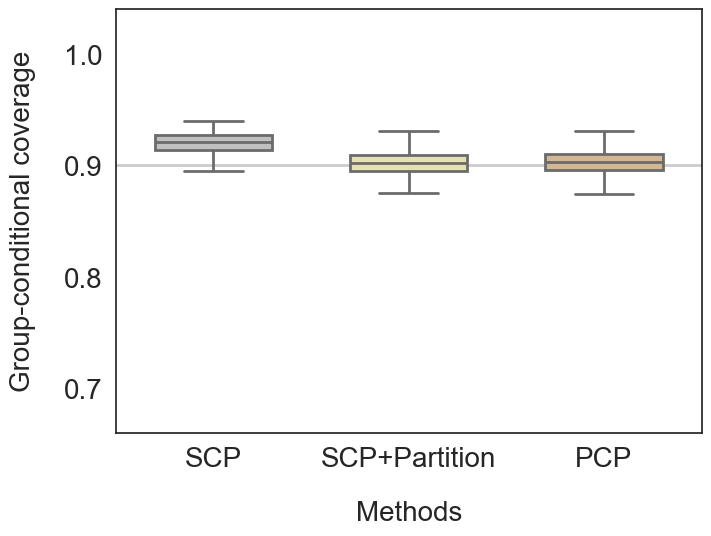

In [55]:
r_scp_ave = np.array(r_m_scp_ave)
r_scp_p_ave = np.array(r_m_scp_p_ave)
r_pcp_ave = np.array(r_m_pcp_ave)

data = pd.DataFrame({'SCP': r_scp_ave, 'SCP+Partition': r_scp_p_ave, 'PCP': r_pcp_ave})
fig, ax = plt.subplots(layout='constrained', figsize=(7,5.25), dpi=100)
data_melted = data.melt(var_name='Group', value_name='Value')

my_pal = {'SCP': "silver",'SCP+Partition': "#EEE8AA" , 'PCP': "#DEB887"}
sns.boxplot(x='Group', y='Value',width=0.6, data=data_melted,fliersize=0,linewidth=2, palette=my_pal)

plt.axhline(y=0.900, color='black',alpha=0.2,linestyle='-', zorder=0,linewidth=2)
ax.set_xlabel('Methods',fontsize=20, labelpad = 20)
ax.set_ylabel('Group-conditional coverage',fontsize=20, labelpad = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0.66,1.04)
plt.yticks([0.7,0.8,0.9,1.0])
plt.show()